# Result Visualizer

Different visualizations of anomaly detection result, including forecasts, reconstructions, anomaly scores, predicted and actual anomalies

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score
import plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.graph_objs as go
import cufflinks as cf
import glob
import sys
import json
cf.go_offline()
init_notebook_mode

sys.path.insert(0, '..')
from plotting import Plotter

from tqdm.notebook import tqdm


In [62]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Specify data result to visualize

In [123]:
#output_path = '../output/MSL'
#output_path = '../output/SMAP'
#output_path = '../output/SMD/1-1'

#output_path = '../output/TELENOR/J0614/03052021_144832' # Only one feature predicted // mcdr_denom
#output_path = '../output/TELENOR/J0614/03052021_154112' # One feature from each sector // mcdr_denom
#output_path = '../output/TELENOR/J0614/03052021_155118' # All features
output_path = '../output/TELENOR/J0614/03052021_164249' # All msdr and mcdr features

#output_path = '../output/TELENOR/J0847/03052021_162618'

#output_path = '../output/TELENOR/J0858/03052021_162832'

#output_path = '../output/TELENOR/J0861/03052021_163629'



In [124]:
plotter = Plotter(output_path)
plotter.result_summary()

Loading results of ../output/TELENOR/J0614/03052021_164249
Result summary:
	No results because labels are not available


## Interactive plot 
- Forecasted value, reconstructed value and actual value for one channel (feature) are plotted in the first plot. You can also specify start and end to limit the x-axis.
- Time steps with actual (true) anomalies are visualized by a light red rectangel, while predicted anomalies by a light blue rectangel. If anomalies are predicted correctly the color of the rectangle will therefore be purple. 
- In the second plot the anomaly score (error) is visualized, together with the threshold used to predict anomalies. To toggle between the error of the channel and the total error for all channels, use ```show_tot_err```. 

In [148]:
# r = "4872-4875"
# start, end = int(r.split('-')[0])-200, int(r.split('-')[1])+100

start, end = None, None
plotter.plot_channel(channel=11, type="test", show_tot_err=True, start=start, end=end)

#### Plot forecasts, reconstructions, true values, anomaly scores, prediction and actual anomalies for all channels in a compact way

<Figure size 432x288 with 0 Axes>

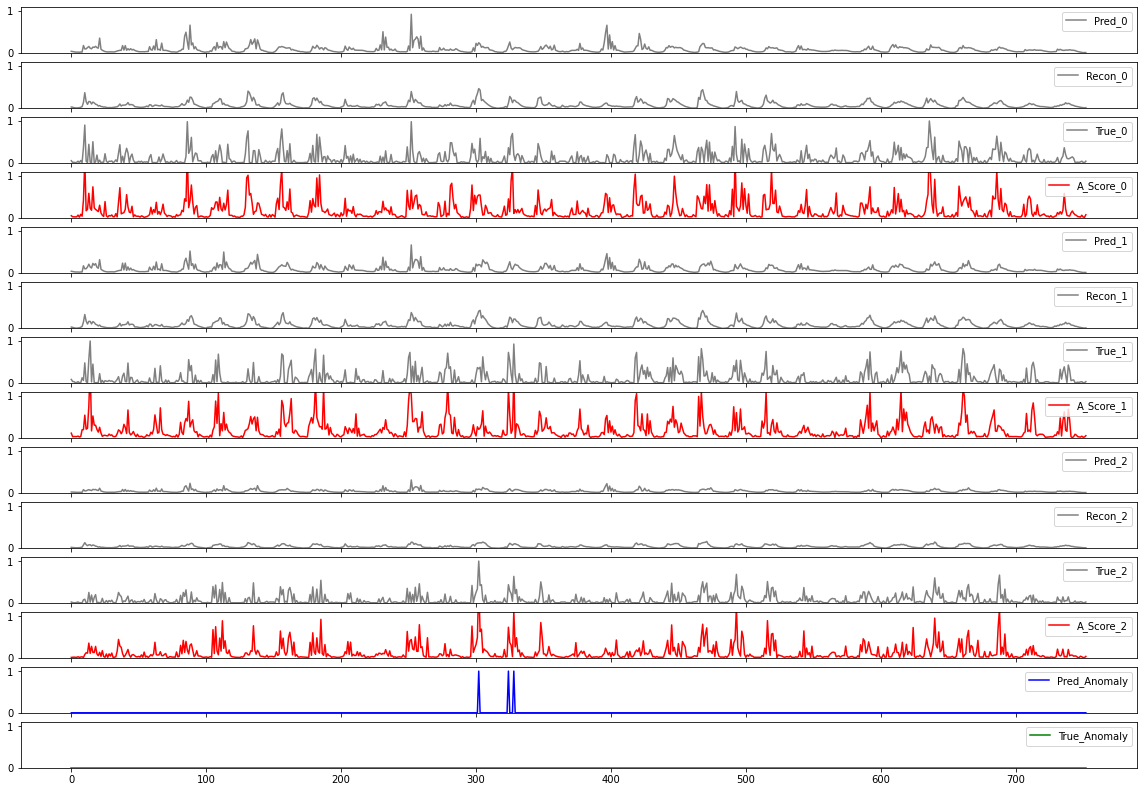

In [25]:
plotter.plot_all_channels(type="test", start=None, end=None)

### Compare errors with true anomalies for single or all channels

In [ ]:
plotter.plot_errors(channel='all')

## Experimenting with other thresholding methods

### Putting some of the evaluation methods here, in order to evaluate with new threshold methods

In [ ]:
def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
            predict (np.ndarray): the predict label
            actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN

def adjust_predicts(score, label, threshold, advance=1, pred=None, calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
            score (np.ndarray): The anomaly score
            label (np.ndarray): The ground-truth label
            threshold (float): The threshold of anomaly score.
                    A point is labeled as "anomaly" if its score is lower than the threshold.
            pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
            calc_latency (bool):
    Returns:
            np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    if pred is None:
        predict = score > threshold
    else:
        predict = pred

    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    latency = 0

    # Added advance in case model predicts anomaly 'in advance' within a small window
    # Advance should be 0 or small
    for i in range(len(score)):
        if any(actual[max(i - advance, 0) : i + 1]) and predict[i] and not anomaly_state:
            anomaly_state = True
            anomaly_count += 1
            for j in range(i, 0, -1):
                if not actual[j]:
                    break
                else:
                    if not predict[j]:
                        predict[j] = True
                        latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict

### First load which data to try other thresholding methods for

In [ ]:
import more_itertools as mit

#data_name = "SMD/1-1"
#data_name = 'MSL'
#data_name = 'SMAP'
#data_name = 'TELENOR/J0847/21042021_232131'
data_name = 'TELENOR/J0858/26042021_201345'

output_path = f'../output/{data_name}'
plotter = Plotter(output_path)
plotter.result_summary()
df = plotter.data
true_anom = df['True_Anomaly'].values
train_scores = np.load(f'{output_path}/train_scores.npy')
test_scores = np.load(f'{output_path}/test_scores.npy')

### For MSL or SMAP
This next cell is not necessary for the SMD dataset or TELENOR.
For MSL, SMAP the time series for different channels are concatinated.
Each has a file called *labeled_anomalies.csv* that holds information about how long the sequences for each channel is (SMAP and MSL shares this file).

In [ ]:
if data_name in ['SMAP', 'MSL']:
    md = pd.read_csv('../datasets/data/labeled_anomalies.csv')
    # If SMAP or MSL, only keep channels belonging to that dataset:
    # Also, P-2 is not included for some reason
    if 'spacecraft' in md.columns:
        md = md[md['spacecraft'] == data_name]
        md = md[md['chan_id'] != 'P-2']

    # Sort values by channel
    md = md.sort_values(by=['chan_id'])
    display(md.head())

    # Getting the cumulative start index for each channel
    sep_cuma = np.cumsum(md['num_values'].values) - 100
    sep_cuma = sep_cuma[:-1]

    # Remove errors for time steps when transition to new channel (as this will be impossible for model to predict)
    buffer = np.arange(1, 5)
    i_remov = np.sort(np.concatenate((sep_cuma, np.array([i+buffer for i in sep_cuma]).flatten(),
                                    np.array([i-buffer for i in sep_cuma]).flatten())))
    i_remov = i_remov[(i_remov < len(test_scores)) & (i_remov >= 0)]
    i_remov = np.sort(np.unique(i_remov))
    if len(i_remov) != 0:
        test_scores[i_remov] = 0

## Threshold method from Telemanom
This method is the one used in [Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding](https://arxiv.org/pdf/1802.04431.pdf).

In simple terms, a threshold is found that, if all values above are removed, would cause the greatest percent decrease in the mean and standard deviation of the smoothed errors es . The function also penalizes for having larger numbers of anomalous values and sequences to prevent overly greedy behavior.

### One threshold: For data where channels are not concatinated 
This concerns SMD. 

In [ ]:
def find_epsilon(errors):
    e_s = errors

    sd_threshold = None
    best_epsilon = None 

    max_score = -10000000
    mean_e_s = np.mean(e_s)
    sd_e_s = np.std(e_s)

    for z in np.arange(2.5, 12, 0.5):
        epsilon = mean_e_s + sd_e_s * z
        pruned_e_s = e_s[e_s < epsilon]

        i_anom = np.argwhere(e_s >= epsilon).reshape(-1,)
        buffer = np.arange(1, 50)
        i_anom = np.sort(np.concatenate((i_anom,
                                        np.array([i+buffer for i in i_anom])
                                         .flatten(),
                                        np.array([i-buffer for i in i_anom])
                                         .flatten())))
        i_anom = i_anom[(i_anom < len(e_s)) & (i_anom >= 0)]
        i_anom = np.sort(np.unique(i_anom))

        if len(i_anom) > 0:
            groups = [list(group) for group in mit.consecutive_groups(i_anom)]
            E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]


            mean_perc_decrease = (mean_e_s - np.mean(pruned_e_s)) / mean_e_s
            sd_perc_decrease = (sd_e_s - np.std(pruned_e_s)) / sd_e_s
            score = (mean_perc_decrease + sd_perc_decrease) #/ (len(E_seq) ** 2 + len(i_anom))

            # sanity checks / guardrails
            if score >= max_score and len(i_anom) < (len(e_s) * 0.5):
                max_score = score
                sd_threshold = z
                best_epsilon = epsilon
                
    return best_epsilon

###  Multiple thresholds: For data with concatinated channels  
In order to properly evaluate the data that consists of concatinations of time series of multiple channels, this next method should be used. It is the exact same method as above, only that a separate threshold is found for each channel.
This is for MSL, SMAP.

In [ ]:
def find_epsilon_multiple_channels(test_scores):

    sep_cuma = np.cumsum(md['num_values'].values) - 100
    epsilons = []
    s = [0] + sep_cuma.tolist()
    for c_start, c_end in [(s[i], s[i+1]) for i in range(len(s)-1)]:
        best_epsilon = None 
        max_score = -10000000
        e_s = test_scores[c_start: c_end+1]
        mean_e_s = np.mean(e_s)
        sd_e_s = np.std(e_s)

        for z in np.arange(2.5, 12, 0.5):
            epsilon = mean_e_s + sd_e_s * z
            pruned_e_s = e_s[e_s < epsilon]

            i_anom = np.argwhere(e_s >= epsilon).reshape(-1,)
            buffer = np.arange(1, 50)
            i_anom = np.sort(np.concatenate((i_anom,
                                            np.array([i+buffer for i in i_anom])
                                             .flatten(),
                                            np.array([i-buffer for i in i_anom])
                                             .flatten())))
            i_anom = i_anom[(i_anom < len(e_s)) & (i_anom >= 0)]
            i_anom = np.sort(np.unique(i_anom))

            if len(i_anom) > 0:
                groups = [list(group) for group in mit.consecutive_groups(i_anom)]
                E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]


                mean_perc_decrease = (mean_e_s - np.mean(pruned_e_s)) / mean_e_s
                sd_perc_decrease = (sd_e_s - np.std(pruned_e_s)) / sd_e_s
                score = (mean_perc_decrease + sd_perc_decrease) / 0.5*(len(E_seq) ** 2 + len(i_anom))

                # sanity checks / guardrails
                if score >= max_score and len(i_anom) < (len(e_s) * 0.5):
                    max_score = score
                    best_epsilon = epsilon

        epsilons.extend([best_epsilon]*(c_end - c_start))
        
    return epsilons
    

## Evaluating predicted anomalies using the new threshold method

In [ ]:
fig, axs = plt.subplots(2, figsize=(30, 10), sharex=True, )

# For SMD, TELENOR
if 'SMD' in data_name or data_name.startswith('TELENOR'):
    best_epsilon = find_epsilon(test_scores)
    print(f'Best threshold found: {best_epsilon}\n')
    if data_name.startswith('TELENOR'):
        pred_anom_adjusted = [0]*len(test_scores)
        f1, precision, recall, TP, TN, FP, FN = None, None, None, None, None, None, None
    else:
        pred_anom_adjusted = adjust_predicts(test_scores, true_anom, best_epsilon)
        f1, precision, recall, TP, TN, FP, FN = calc_point2point(pred_anom_adjusted, true_anom)
    epsilons = [best_epsilon for i in range(len(test_scores))]

# For MSL, SMAP
else:
    epsilons = find_epsilon_multiple_channels(test_scores)
    pred_anom_adjusted = adjust_predicts(test_scores, true_anom, epsilons)
    f1, precision, recall, TP, TN, FP, FN = calc_point2point(pred_anom_adjusted, true_anom)
        
    if data_name == 'MSL':
        axs[0].set_ylim([0, 5])

        

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

axs[0].plot(test_scores, c='r', label='anomaly scores')
axs[0].plot(epsilons, linestyle='dashed', c='black', label='threshold')
axs[1].plot(pred_anom_adjusted, label='predicted anomalies', alpha=0.7)
axs[1].plot(true_anom, label='actual anomalies', alpha=0.7)
fig.legend(prop={'size': 20})
plt.show()
    


## Interactive plot with the next threshold

In [ ]:
#plotter.data['Pred_Anomaly'] = pred_anom_adjusted
plotter.data['threshold'] = epsilons
plotter.data['Pred_Anomaly'] = pred_anom_adjusted
plotter.data['Tot_A_Score'] = test_scores

start, end = None, None
plotter.plot_channel(channel=2, show_tot_err=False, start=start, end=end)

### Method to get results from all subparts of SMD

In [ ]:
# Aggregate results for all subparts of dataset 
result_dir = '../output/SMD'
precisions = []
recalls = []
f1s = []

for folder in os.listdir(result_dir):
    path = f'{result_dir}/{folder}/summary.txt'
    if not os.path.exists(path):
        print(f'Folder {folder} does not has a summary.txt file')
        continue
    with open(path) as f:
        result_dict = json.load(f)['pot_result']
        if result_dict['f1'] < 0.3:
            print(path)
        precisions.append(result_dict['precision'])
        recalls.append(result_dict['recall'])
        f1s.append(result_dict['f1'])
print('-- Done')

precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)

print(f'Avg precision: {precisions.mean():.4f}')
print(f'Avg recall: {recalls.mean():.4f}')
print(f'Avg f1: {f1s.mean():.4f}')

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].set_title('Precisions')
axs[0].boxplot(precisions);
axs[1].set_title('Recalls')
axs[1].boxplot(recalls);
axs[2].set_title('F1s')
axs[2].boxplot(f1s);
plt.show();

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].hist(precisions, bins=len(precisions));
axs[1].hist(recalls, bins=len(recalls));
axs[2].hist(f1s, bins=len(f1s));
plt.show();